# Demand forecasting model evaluation and optimisation v2

A mistake was found where missing lags were being filled with values of 0. This was found to maybe be making hte models confuse treu 0 sales values with these missing ones. After this was fixed in the preprocessing pipeline, this notebooking explores the impact of this change in model performance.. 

## 1. Exploratory Data Analysis (EDA)

In this section, a dataset previously generated through the preprocessing pipeline is loaded. This dataset holds the exact same timeline of data as the one used for the models trained with timestamp `20240928_134943`. However, this version has been run through the pipeline after a small but impactful change; previously lag and rolling averages were replaced with 0 when NaN, which could be causing the model to confuse them with true 0 sales. 

The aim here is to make sure the dataset has the same charcateristics and structure as the previously employed dataset, before training and evaluating new models..

### 1.1. Data overview 

In [3]:
import pandas as pd

# Load the preprocessed data (dataset not available locally, access details in porject report)
df = pd.read_csv('../data/historical/backup/processed_data_20241005_173107.csv')

# Avoid long scientific notation
pd.set_option('display.float_format', '{:.4f}'.format)

def describe_dataset(df):
    # Ensure datetime format throughout
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Display data  size, columns, and their types
    print(df.info())

    # Display the number of unique products and categories
    num_products = df['product_id_encoded'].nunique()
    num_categories = df['category_encoded'].nunique()
    print(f"Number of unique products: {num_products}")
    print(f"Number of unique categories: {num_categories}")

    # Display the date range
    print(f"Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values detected.")
    else:
        print("Missing values found in the following columns:")
        print(missing[missing > 0]) 

describe_dataset(df)

/var/folders/fp/13hwwrjs1l7b1bb0kcbdkw5w0000gn/T/ipykernel_7676/3523655596.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/historical/backup/processed_data_20241005_173107.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351182 entries, 0 to 1351181
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   product_id                1351182 non-null  object        
 1   original_product_id       614166 non-null   object        
 2   product_name              1351182 non-null  object        
 3   category                  1351182 non-null  object        
 4   product_id_encoded        1351182 non-null  int64         
 5   category_encoded          1351182 non-null  int64         
 6   quantity                  1351182 non-null  int64         
 7   per_item_value            1351182 non-null  float64       
 8   in_stock                  1351182 non-null  int64         
 9   year                      1351182 non-null  int64         
 10  week                      1351182 non-null  int64         
 11  weekday                   1351182 non-null  int64 

### 1.2. Distribution of the target variable ('quantity') and outlier detection


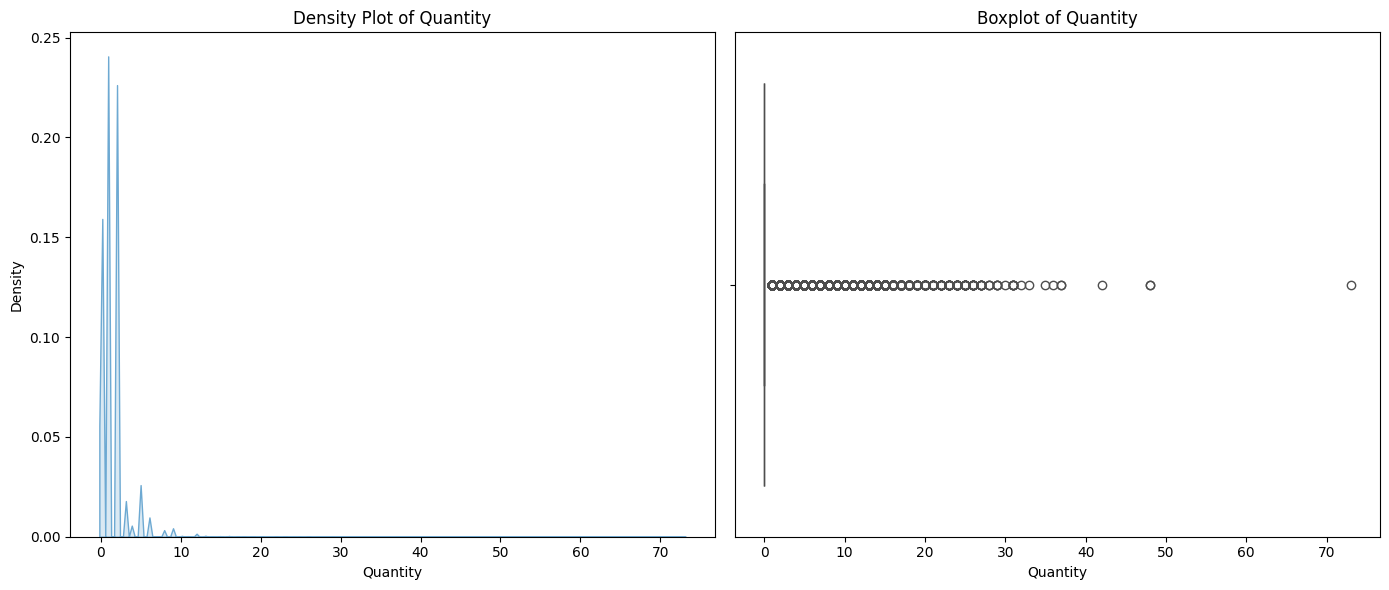

Summary statistics of 'quantity' column:
count   1351182.0000
mean          0.3600
std           1.1036
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          73.0000
Name: quantity, dtype: float64
Number of outliers detected: 24


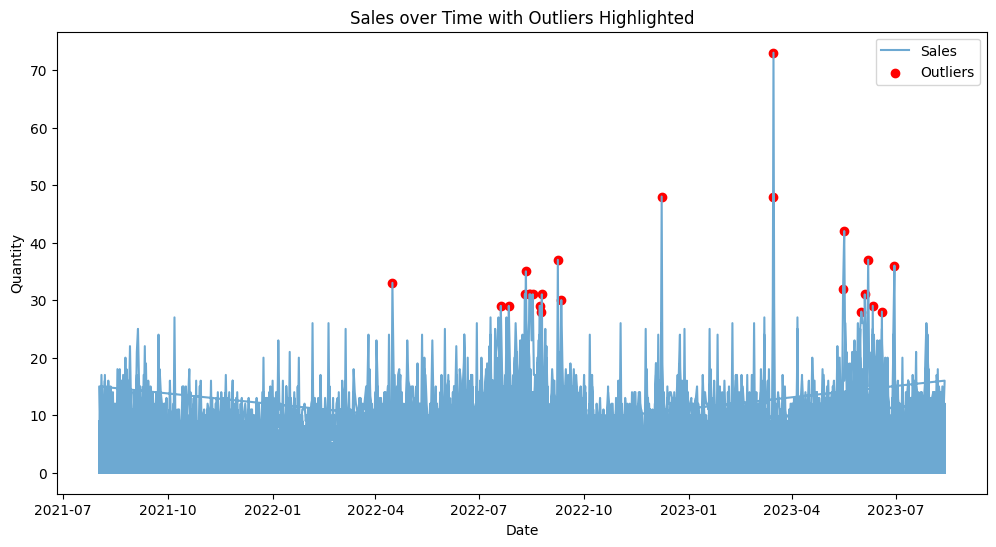

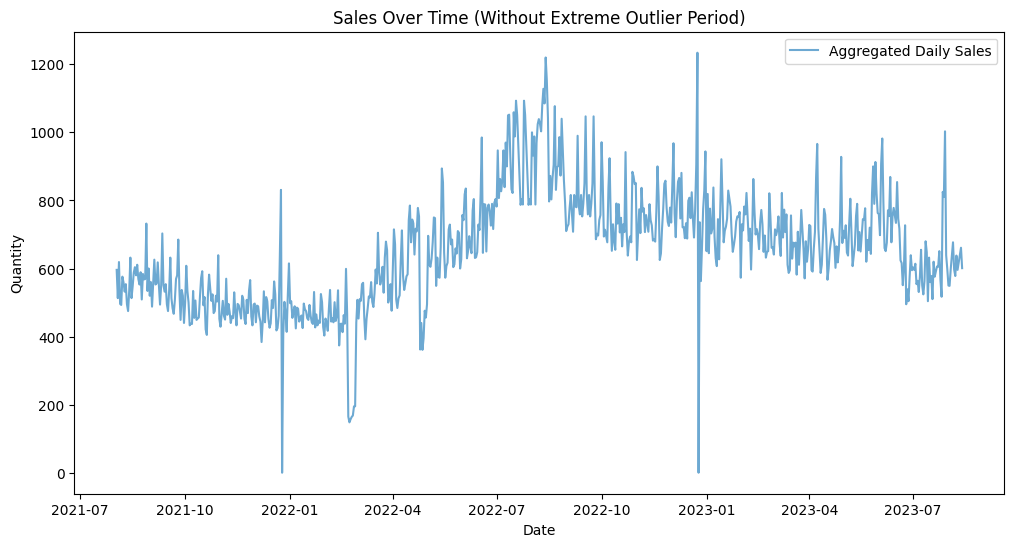

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colour palette
colours = sns.color_palette("Blues_d", n_colors=40)

def summarise_target_stats(df):
    # Summarise statistics of the target variable
    print("Summary statistics of 'quantity' column:")
    print(df['quantity'].describe())


def plot_target_density(df):
    # Define figure and axes for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the distribution of quantity
    sns.kdeplot(df['quantity'], fill=True, color=colours[10], ax=axes[0])
    axes[0].set_title('Density Plot of Quantity')
    axes[0].set_xlabel('Quantity')
    axes[0].set_ylabel('Density')

    # Boxplot quantity
    sns.boxplot(x=df['quantity'], color=colours[18], ax=axes[1])
    axes[1].set_title('Boxplot of Quantity')
    axes[1].set_xlabel('Quantity')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

def detect_flag_plot_outliers(df, lower_percentile, upper_percentile):
    # Calculate IQR and define bounds based on percentiles
    Q1 = df['quantity'].quantile(lower_percentile)
    Q3 = df['quantity'].quantile(upper_percentile)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df['quantity'] < lower_bound) | (df['quantity'] > upper_bound)]
    print(f"Number of outliers detected: {len(outliers)}")

    # Create a flag feature
    df.loc[:, 'is_outlier'] = df.index.isin(outliers.index).astype(int)

    # Plot sales over time with outliers highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['quantity'], label='Sales', color=colours[10])
    plt.scatter(outliers['date'], outliers['quantity'], color='red', label='Outliers')
    plt.title('Sales over Time with Outliers Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

def plot_sales_over_time_aggregated(df):
    # Aggregate sales by date (summing the quantity for each day)
    df_aggregated = df.groupby('date', as_index=False)['quantity'].sum()

    # Plot the aggregated sales over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_aggregated['date'], df_aggregated['quantity'], label='Aggregated Daily Sales', color=colours[10])
    plt.title('Sales Over Time (Without Extreme Outlier Period)')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

plot_target_density(df)
summarise_target_stats(df)
detect_flag_plot_outliers(df, 0.001, 0.999)
plot_sales_over_time_aggregated(df)

### 1.4. Product- and category-level analysis

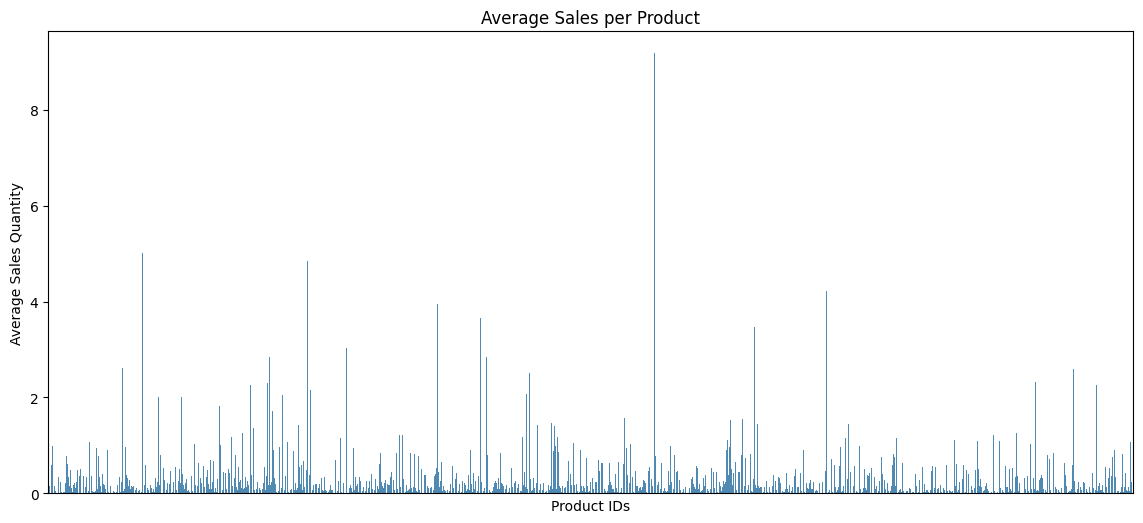

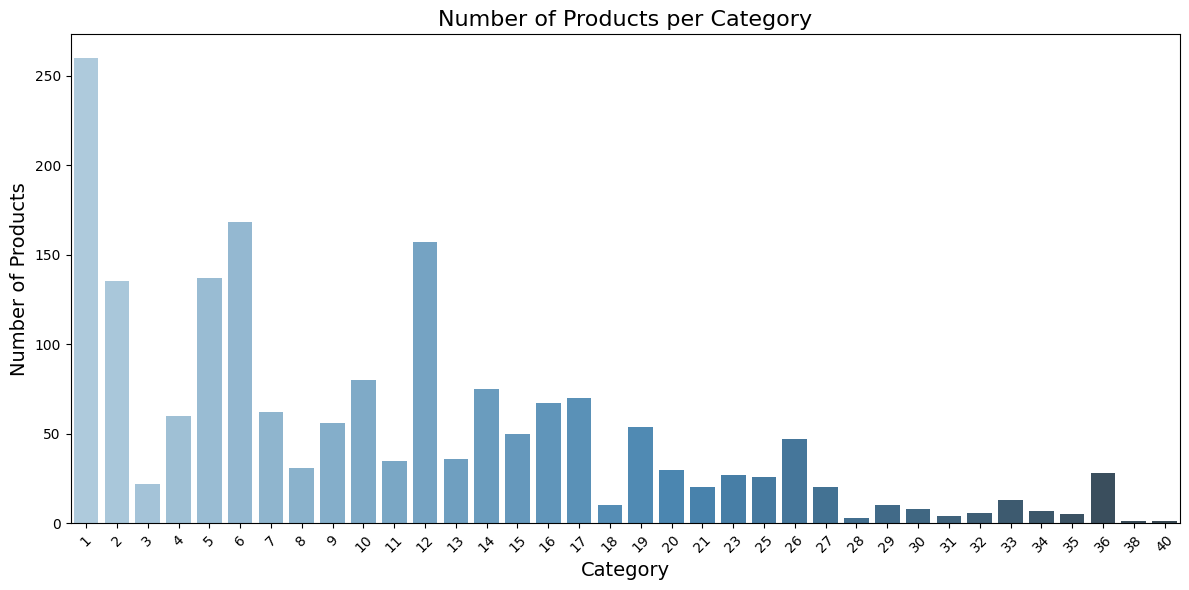

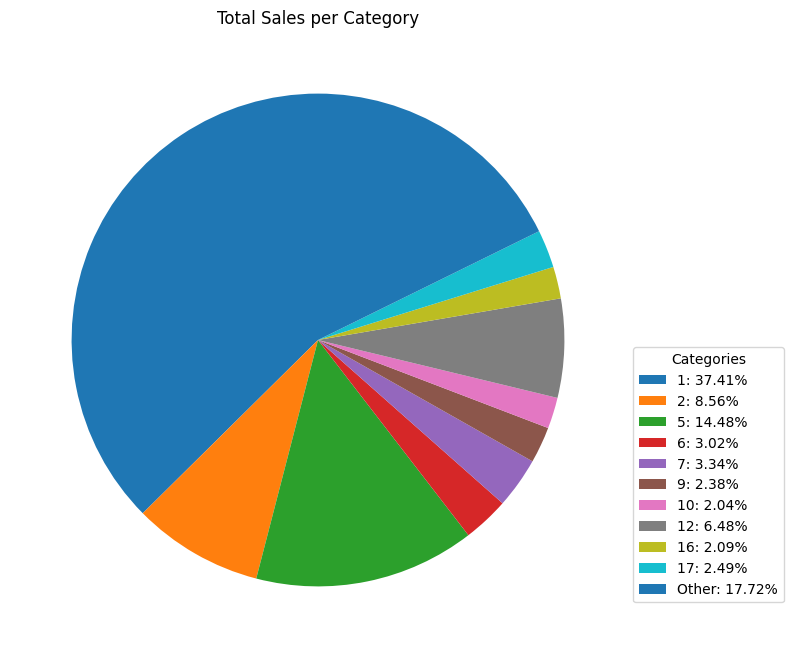

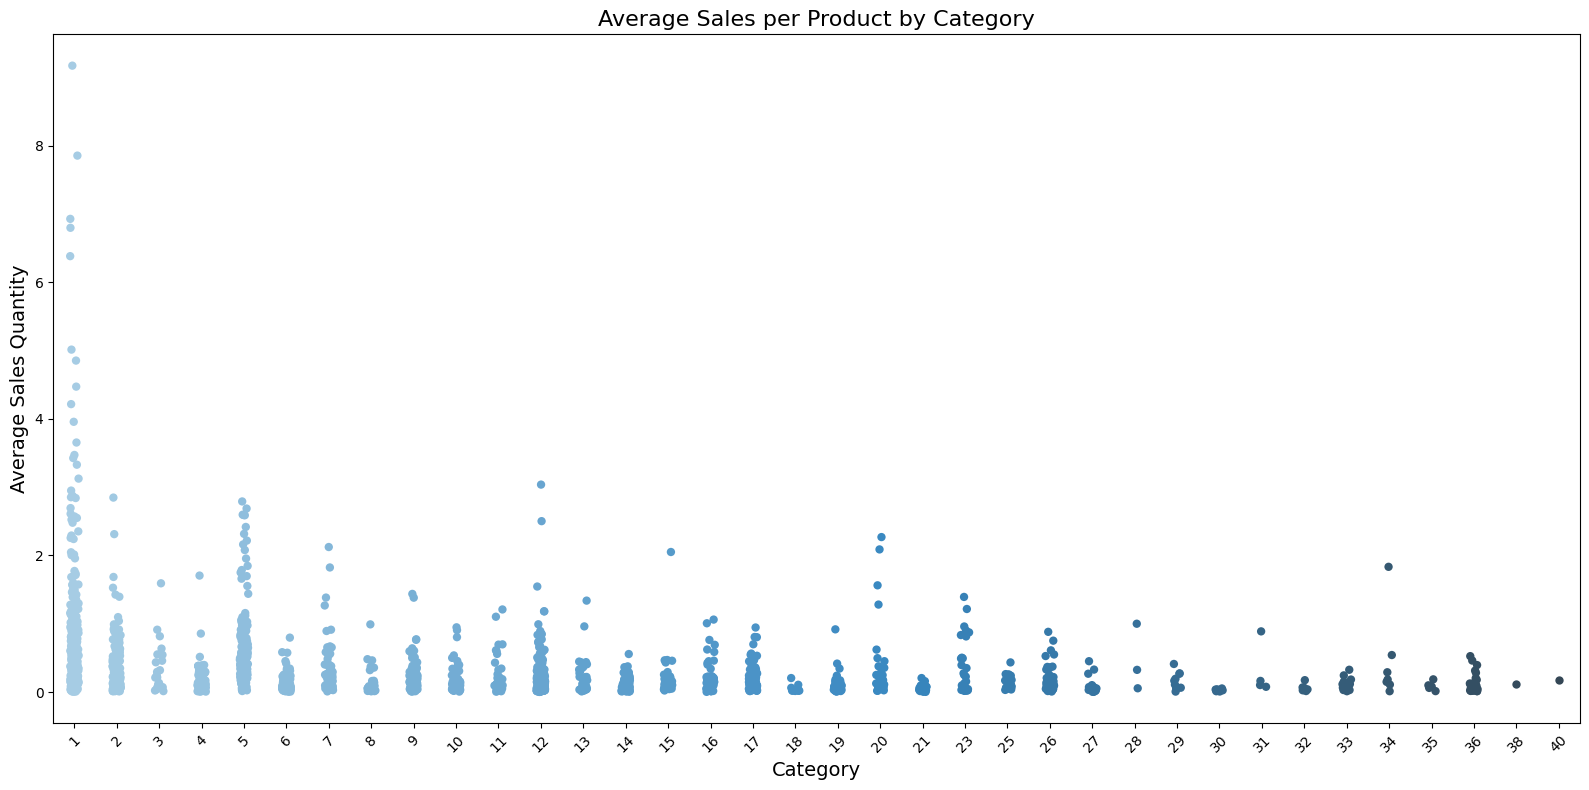

In [ ]:
# Group by product and calculate average sales
product_sales = df.groupby('product_id_encoded')['quantity'].mean().sort_values(ascending=False)

# Plot average sales per product
plt.figure(figsize=(14, 6))
sns.barplot(x=product_sales.index, y=product_sales.values, color=colours[18])
plt.title('Average Sales per Product')
plt.xlabel('Product IDs')
plt.ylabel('Average Sales Quantity')
plt.xticks([])  # Hide product IDs for clarity
plt.show()

# Count the number of unique products per category
products_per_category = df.groupby('category_encoded')['product_id_encoded'].nunique().reset_index()
products_per_category.columns = ['category_encoded', 'num_products']

# Plot products per category
plt.figure(figsize=(12, 6))
sns.barplot(x='category_encoded', y='num_products', data=products_per_category, palette=colours[0:36], hue='category_encoded', legend=False)
plt.title('Number of Products per Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate sales percentages per category
category_sales = df.groupby('category_encoded')['quantity'].sum()
category_sales_percentage = category_sales / category_sales.sum() * 100

# Split categories into major and minor ones based on a threshold
threshold = 2 # Threshold percentage for small categories 
major_categories = category_sales_percentage[category_sales_percentage >= threshold]
minor_categories = category_sales_percentage[category_sales_percentage < threshold]

# Add an "Other" category for all small categories
if len(minor_categories) > 0:
    major_categories['Other'] = minor_categories.sum()

# Create pie chart
plt.figure(figsize=(8, 8))
patches, texts = plt.pie(major_categories, startangle=90)

# Create legend with category code and percentage
legend_labels = [f'{cat}: {round(perc, 2)}%' if cat != 'Other' else f'Other: {round(perc, 2)}%' for cat, perc in zip(major_categories.index, major_categories.values)]
plt.legend(patches, legend_labels, loc="best", bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('Total Sales per Category')
plt.show()

# Calculate the average sales per product within each category
product_avg_sales_per_category = df.groupby(['category_encoded', 'product_id_encoded'])['quantity'].mean().reset_index()

# Create a strip plot
plt.figure(figsize=(16, 8))
sns.stripplot(
    x='category_encoded', 
    y='quantity', 
    data=product_avg_sales_per_category,
    jitter=True,  # Avoid dots stacking on top of each other
    palette=colours[0:36],
    marker='o',
    size=6,
    hue='category_encoded',
    legend=False
)
plt.title('Average Sales per Product by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Average Sales Quantity', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5. Sales trends over time

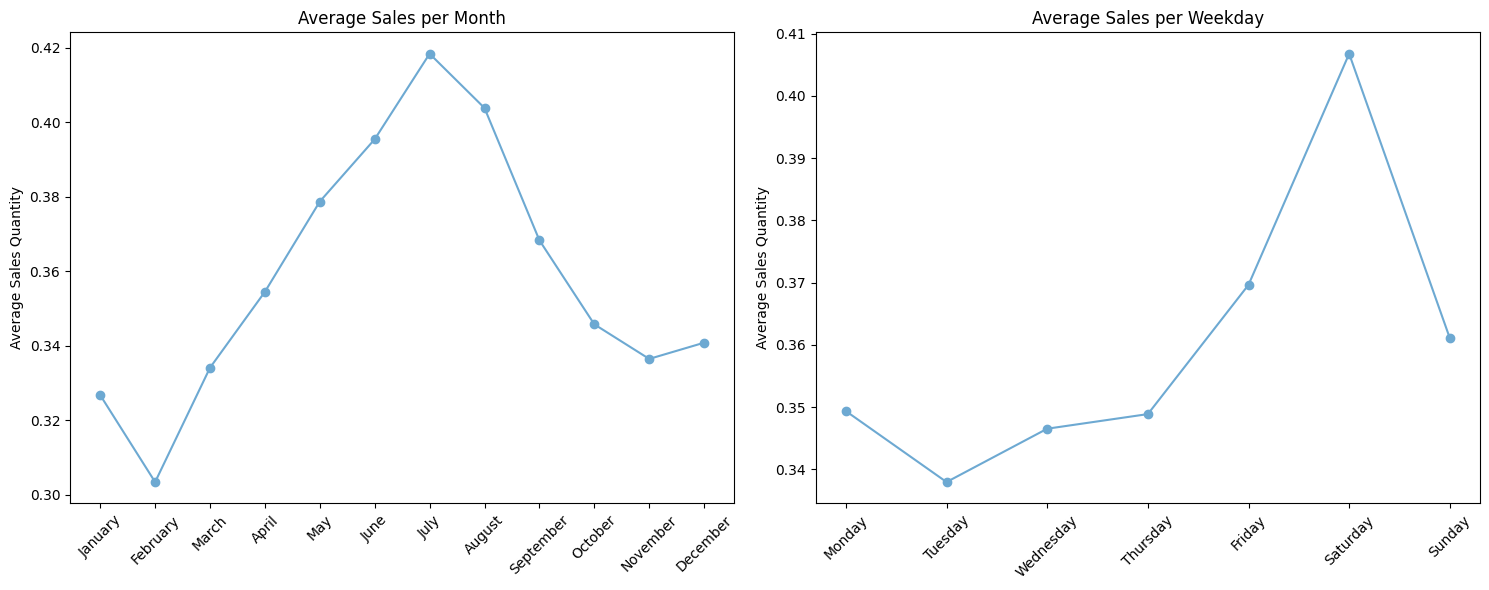

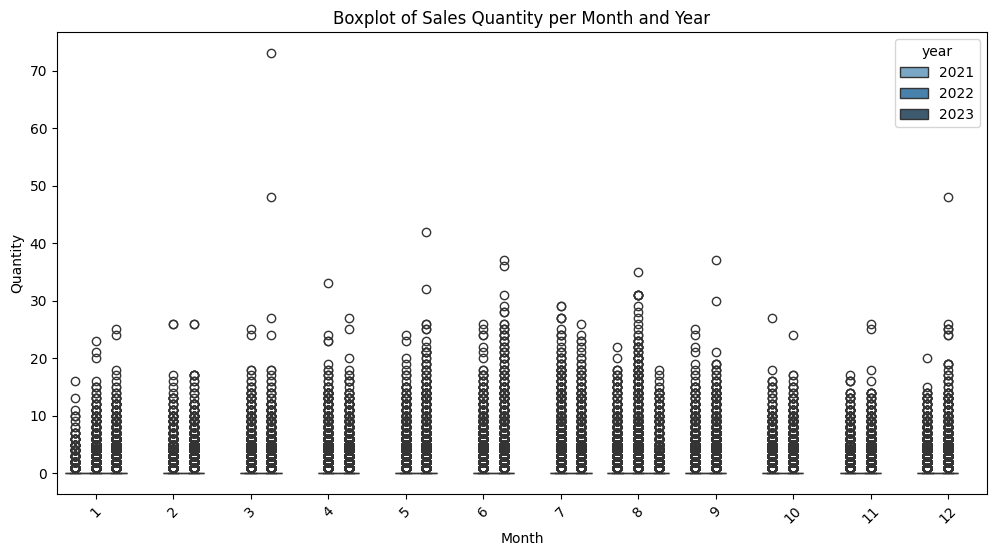

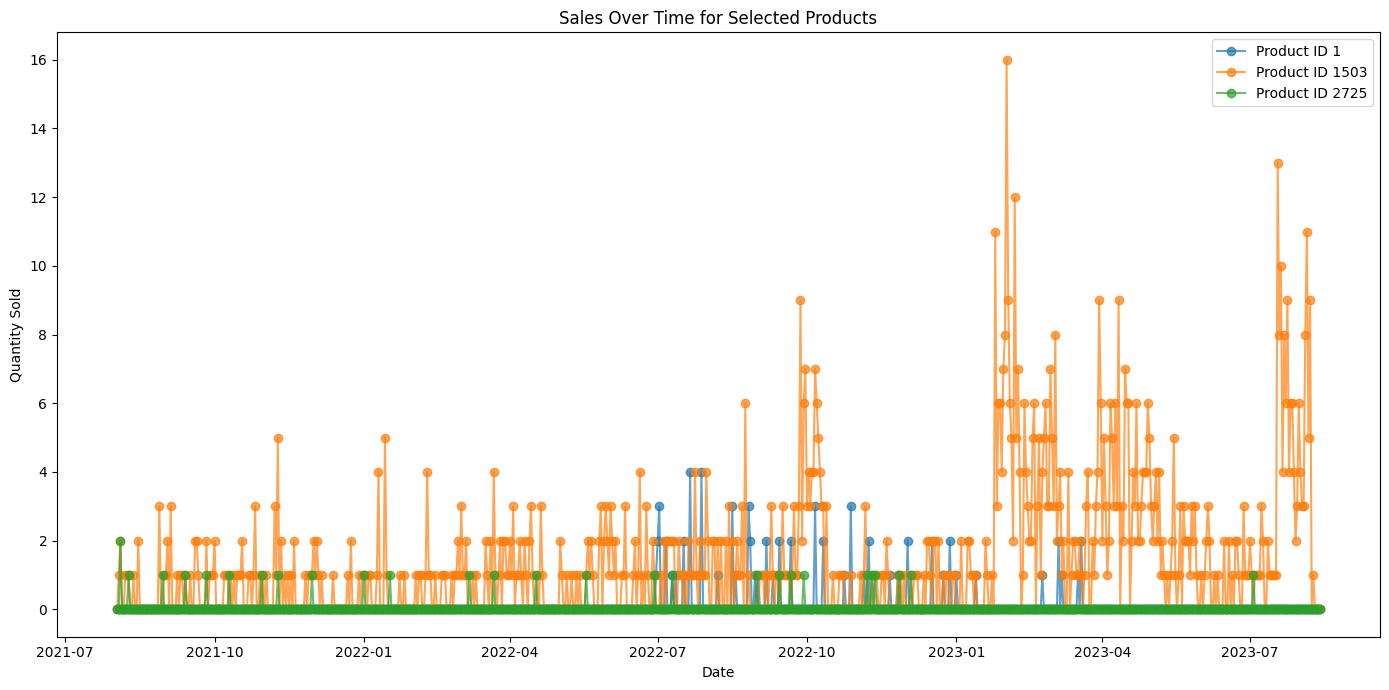

In [ ]:
import calendar

# Group sales data by month and weekday 
monthly_sales = df.groupby(df['date'].dt.month)['quantity'].mean()
weekday_sales = df.groupby(df['date'].dt.weekday)['quantity'].mean()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot average sales per month
axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o', color=colours[10])
axes[0].set_title('Average Sales per Month')
axes[0].set_ylabel('Average Sales Quantity')
axes[0].set_xticks(monthly_sales.index)
axes[0].set_xticklabels([calendar.month_name[i] for i in monthly_sales.index], rotation=45)

# Plot average sales per weekday
axes[1].plot(weekday_sales.index, weekday_sales.values, marker='o', color=colours[10])
axes[1].set_title('Average Sales per Weekday')
axes[1].set_ylabel('Average Sales Quantity')
axes[1].set_xticks(weekday_sales.index)
axes[1].set_xticklabels([calendar.day_name[i] for i in weekday_sales.index], rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Boxplot sales per month and year
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='quantity', hue='year', data=df, palette=[colours[10], colours[20], colours[30],])
plt.title('Boxplot of Sales Quantity per Month and Year')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

# Select 3 sample products based on the most common products
sample_products = df['product_id_encoded'].value_counts().index[:3]

# Plot products' sales over time
plt.figure(figsize=(14, 7))

# Plot sales for each product in a single plot
for product in sample_products:
    product_sales = df[df['product_id_encoded'] == product]
    
    plt.plot(product_sales['date'], product_sales['quantity'], label=f'Product ID {product}', marker='o', alpha=0.7)

# Add title, labels, and legend
plt.title('Sales Over Time for Selected Products')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


### 1.6. Correlation matrix of key features and quantity

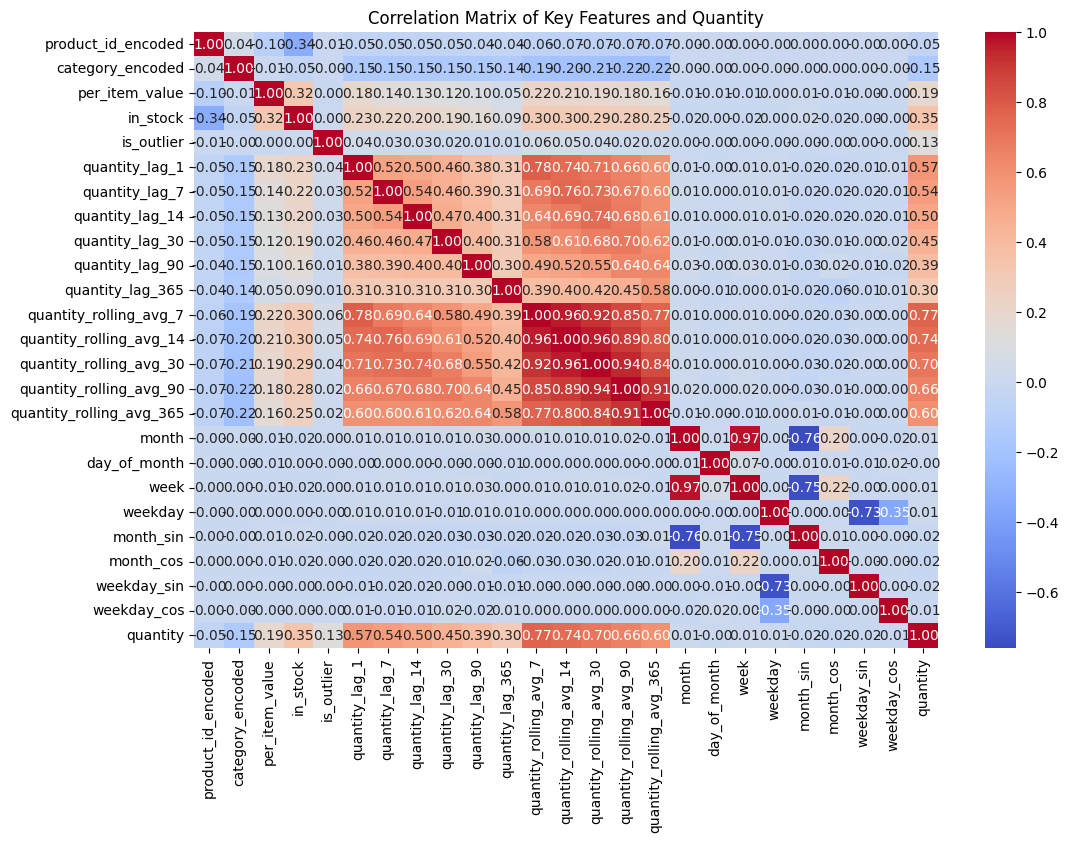

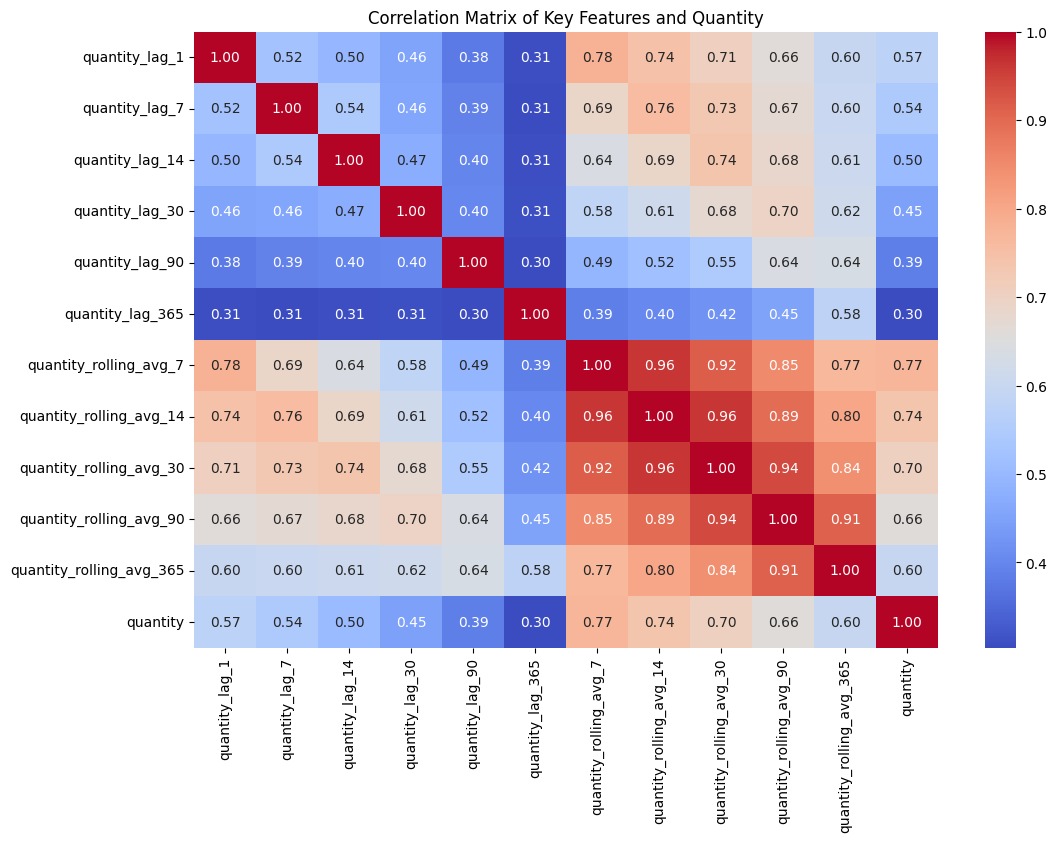

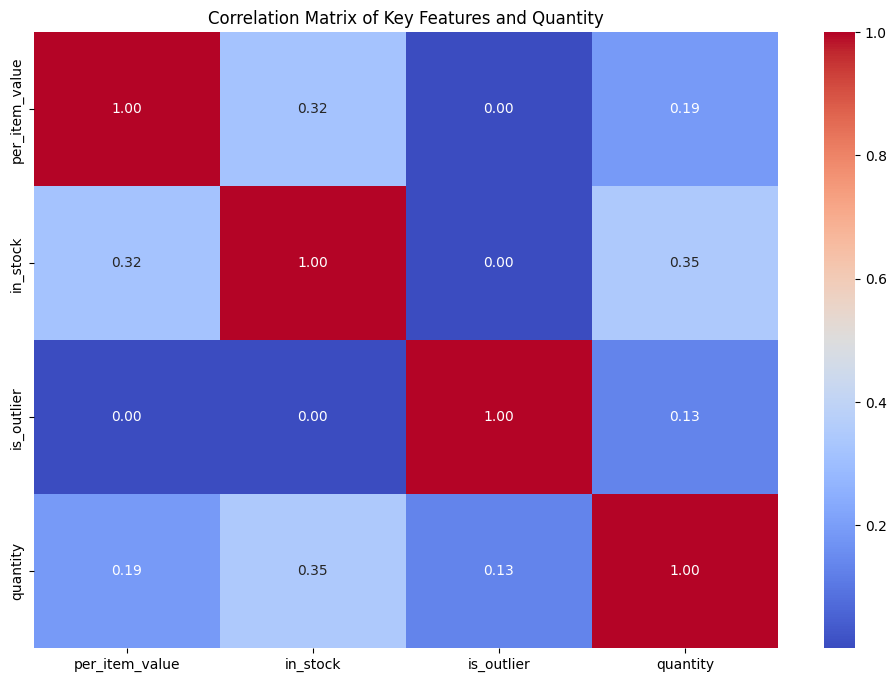

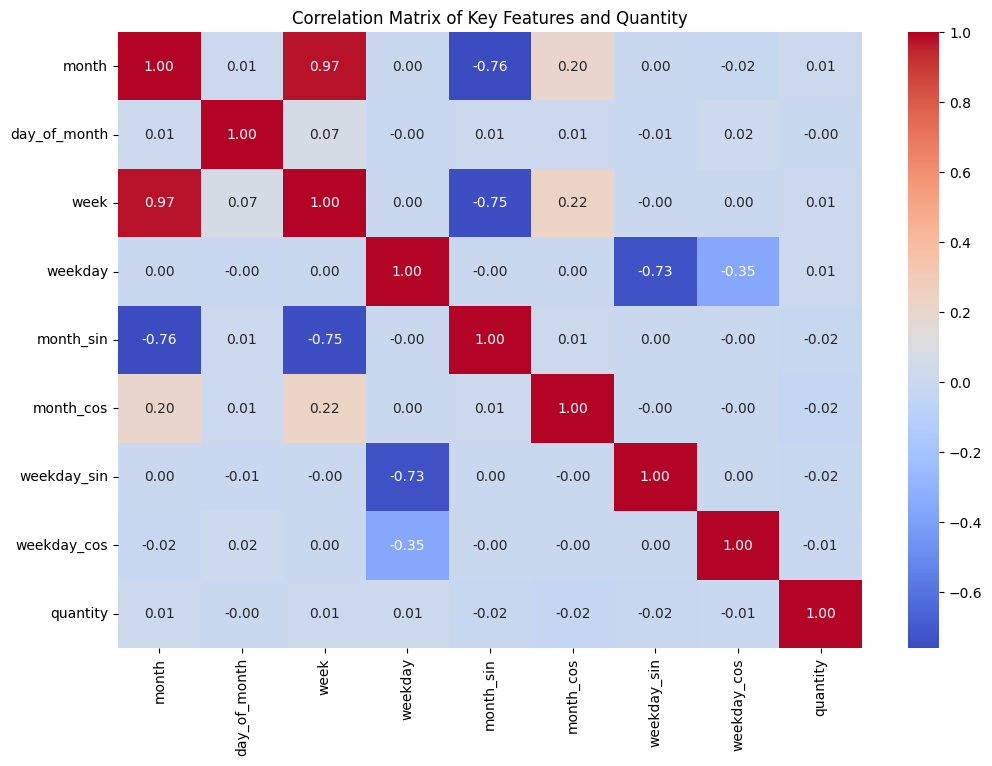

In [ ]:
def analyse_correlation(df, features):
    # Generate correlation matrix
    corr_matrix = df[features + ['quantity']].corr()

    # Plot correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Key Features and Quantity')
    plt.show()

# Check correlations between features of interest and the target
all_features_of_interest = [
    'product_id_encoded', 'category_encoded', 'per_item_value', 'in_stock', 'is_outlier',
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_14', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365', 
    'month', 'day_of_month', 'week', 'weekday', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
]
analyse_correlation(df, all_features_of_interest)

# Check correlations between time series features and the target
time_series_features = [
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_14', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365', 
]
analyse_correlation(df, time_series_features)

# Check correlations between time series features and the target
product_info_features = [
    'per_item_value', 'in_stock', 'is_outlier',
]
analyse_correlation(df, product_info_features)

# Check correlations between time features and the target
time_features = [
    'month', 'day_of_month', 'week', 'weekday', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
]
analyse_correlation(df, time_features)

### 1.7. Key takeaways from the EDA

Everything looks in place: outputs are identical, except for the amount of missing values which in this dataset is significant, particularly confirming that a considerable amount of lag values were being filled in with 0:
quantity_lag_1           1821
quantity_lag_7          12747
quantity_lag_14         25494
quantity_lag_30         54630
quantity_lag_90        163890
quantity_lag_365       664665

In [4]:
from sklearn.model_selection import TimeSeriesSplit

# Remove outliers



# Define target and features
target = 'quantity'

features = [
    'product_id_encoded', 'category_encoded', 
    'quantity_lag_1', 'quantity_lag_7',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365',
    'month_cos', 'month_sin', 'weekday_cos', 'weekday_sin', 
    'in_stock', 'per_item_value',
]

# Split the data based on training until week 31 of 2022
split_date = '2022-08-31'
train_data = df[df['date'] <= split_date]
test_data = df[df['date'] > split_date]

def split_train_test(train_data, test_data, features, target):
    # Separate the features and target variables for training nad testing
    X_train = train_data[features]
    y_train = train_data[target] 
    X_test = test_data[features]
    y_test = test_data[target]

    return X_train, y_train, X_test, y_test

def setup_time_series_split(n_splits=5):
    # TimeSeriesSplit with 5 splits
    return TimeSeriesSplit(n_splits)


X_train, y_train, X_test, y_test = split_train_test(train_data, test_data, features, target)

tscv = setup_time_series_split(5)

## 3. Training models

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb

def random_search_train_model(model, param_grid, X_train, y_train, tscv, scoring_metric='neg_mean_absolute_error', n_iter=50):
    # Set up RandomizedSearchCV with TimeSeriesSplit
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring_metric,  
        cv=tscv,  # Apply TimeSeriesSplit
        verbose=1,
        random_state=42,  # Set random state for reproducibility
        n_jobs=2  # Workers stopped when using all cores
    )

    # Fit the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters from the search
    print(f"Best parameters found: {random_search.best_params_}")

    # Extract the trained model with optimal hyperparameters based on the MAE score
    return random_search.best_estimator_


### 3.3. XGBoost model training

In [6]:
# Initialise the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7],
}

xgb_best_model = random_search_train_model(xgb_model, xgb_param_grid, X_train, y_train, tscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}


### 3.4. LightGBM model training

In [8]:
# Initialise the LightGBM model
lgb_model = lgb.LGBMRegressor(verbose=-1)  # Avoid printing progress for clarity

# Define parameter grid
lgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'num_leaves': [31, 61], 
    'min_child_samples': [50, 100],
}

lgb_best_model = random_search_train_model(lgb_model, lgb_param_grid, X_train, y_train, tscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 50, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


## 4. Model evaluation and comparison

The randomised search for XGBoost has returned the same best parameters:
`{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}`

Whereas for LightGBM they have changed considerably:
Before: `{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}`
Now: `{'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 61, 'n_estimators': 100, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}`

The performance metrics haven't changed much, slightly better for XGBoost and worse for LightGBM. 

Feature importance also hasn't changed, only `quantity_rolling_avg30` and `quantity_lag_7` have been flipped around for XGBoost.

Model: XGBoost
MAE: 0.25480012373163363, RMSE: 0.6589610217168242, R²: 0.6555905938148499


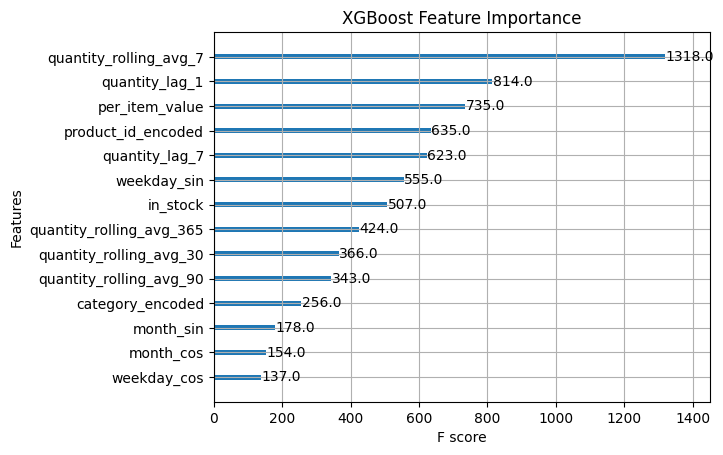

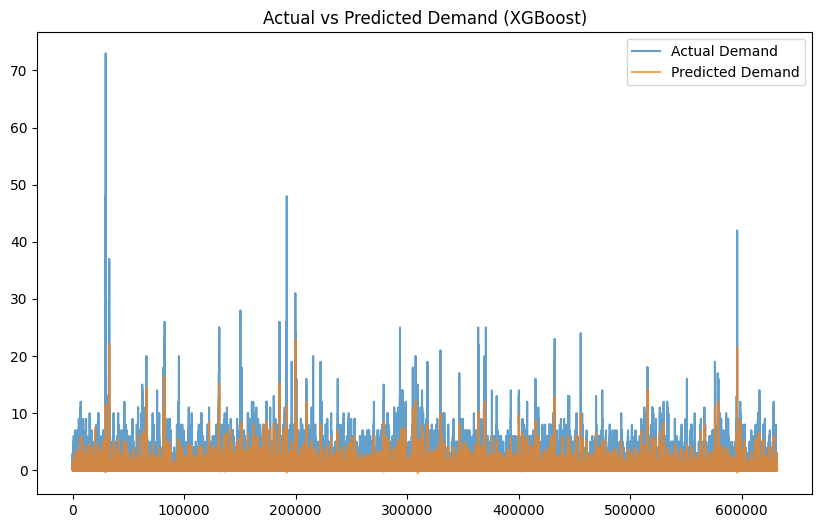

Model: LightGBM
MAE: 0.25752816139944523, RMSE: 0.6590208242989969, R²: 0.6555279638971587


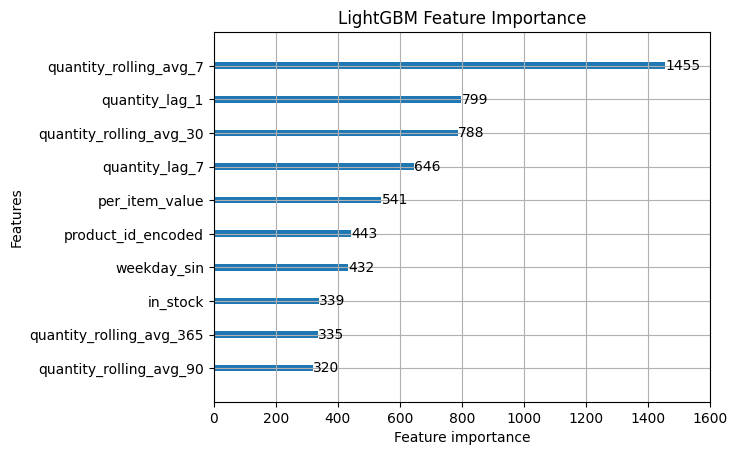

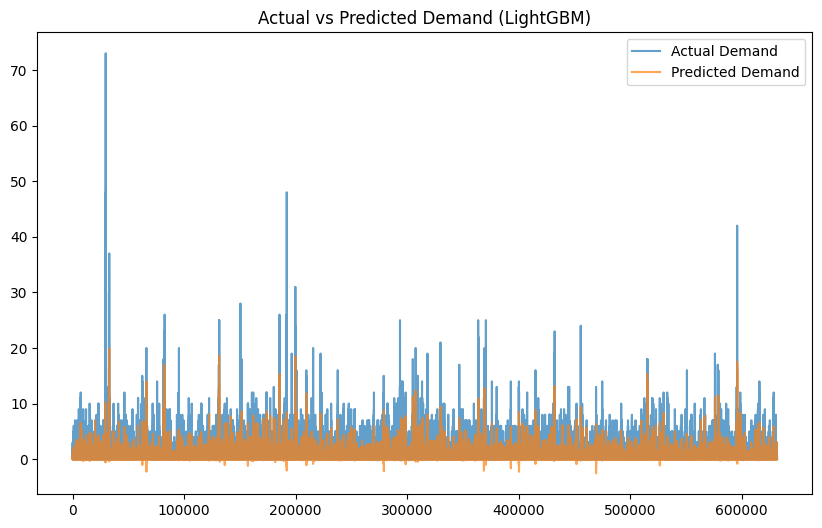

      Metric  XGBoost  LightGBM
0        MAE   0.2548    0.2575
1       RMSE   0.6590    0.6590
2  R-squared   0.6556    0.6555


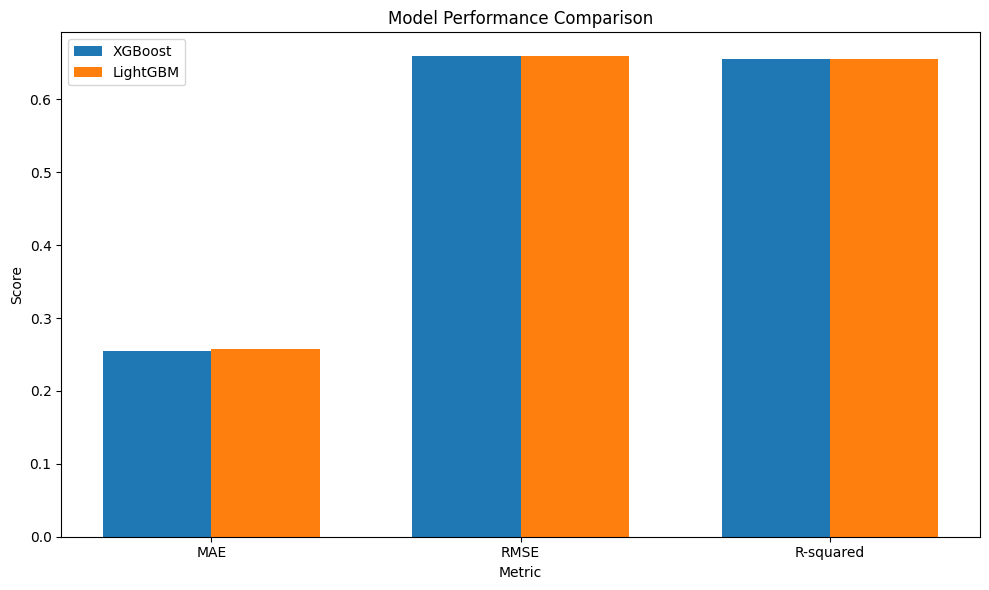

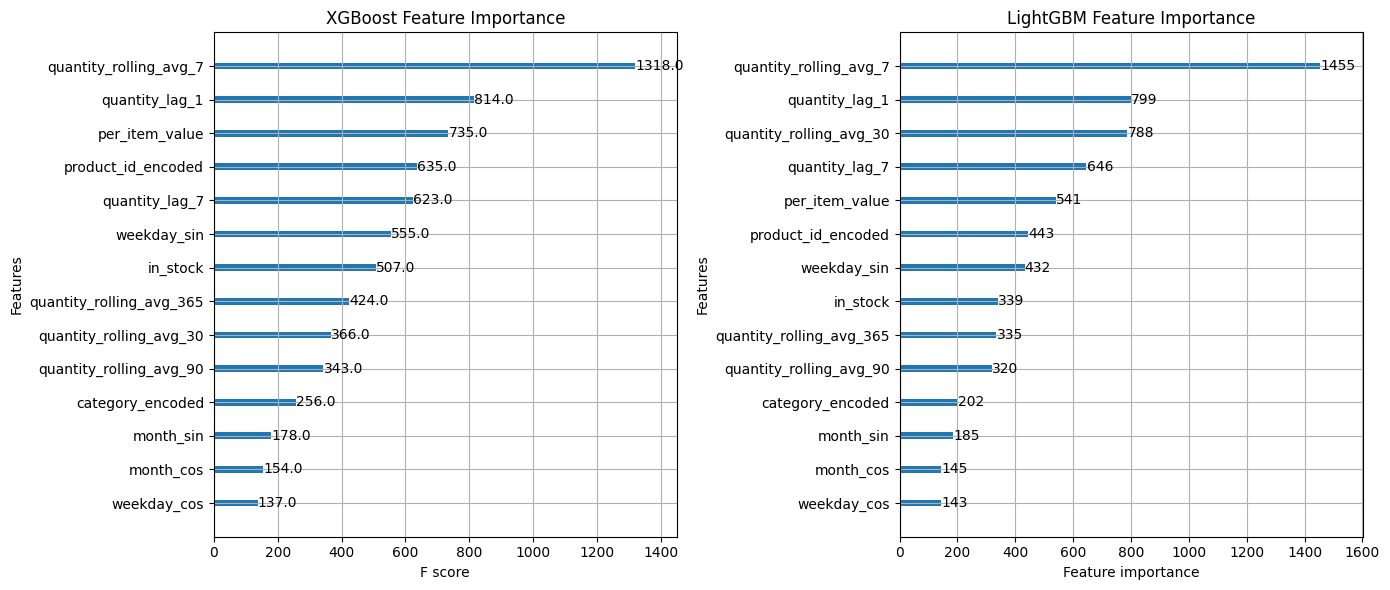

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def plot_feature_importance(model):
    if isinstance(model, xgb.XGBRegressor):
        xgb.plot_importance(model)
        plt.title('XGBoost Feature Importance')
    elif isinstance(model, lgb.LGBMRegressor):
        lgb.plot_importance(model, max_num_features=10)
        plt.title('LightGBM Feature Importance')
    plt.show()

import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, display=True, plot=False, model_name=''):
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    if display:
        print(f"Model: {model_name}")
        print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

        # Plot feature importance if requested
        plot_feature_importance(model)
    
    # Plot actual vs predicted values if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.values, label="Actual Demand", alpha=0.7)
        plt.plot(y_pred, label="Predicted Demand", alpha=0.7)
        plt.legend()
        plt.title(f'Actual vs Predicted Demand ({model_name})')
        plt.show()

    return mae, rmse, r2
def compare_models(model_1, model_2, X_test, y_test):
    # Evaluate XGBoost model and plot results
    model_1_mae, model_1_rmse, model_1_r2 = evaluate_model(model_1, X_test, y_test, display=True, plot=True, model_name='XGBoost')

    # Evaluate LightGBM model and plot results
    model_2_mae, model_2_rmse, model_2_r2 = evaluate_model(model_2, X_test, y_test, display=True, plot=True, model_name='LightGBM')

    # Define metrics varuiables
    metrics = ['MAE', 'RMSE', 'R-squared']
    model_1_metrics = [model_1_mae, model_1_rmse, model_1_r2]
    model_2_metrics = [model_2_mae, model_2_rmse, model_2_r2]

    # Print a comparison table
    metrics_data = {
        'Metric': metrics,
        'XGBoost': model_1_metrics,
        'LightGBM': model_2_metrics
    }
    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df)

    # Create bar chart comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))

    # Bar positions
    ax.bar(index, model_1_metrics, bar_width, label='XGBoost')
    ax.bar(index + bar_width, model_2_metrics, bar_width, label='LightGBM')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Metric')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)

    # Add legend
    ax.legend()

    # Show the bar chart
    plt.tight_layout()
    plt.show()

    # Plot feature importance side by side for both models
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot XGBoost feature importance
    xgb.plot_importance(model_1, ax=axes[0])
    axes[0].set_title('XGBoost Feature Importance')

    # Plot LightGBM feature importance
    lgb.plot_importance(model_2, ax=axes[1])
    axes[1].set_title('LightGBM Feature Importance')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()
# Assuming xgb_best_model and lgb_best_model have been trained using RandomizedSearchCV as in your initial code

# Compare XGBoost and LightGBM models with visualizations
compare_models(xgb_best_model, lgb_best_model, X_test, y_test)


## 5. Model saving and versioning

In this section, the best-performing models are saved for future use.


In [ ]:
import joblib
from datetime import datetime

def save_model(model, filename):
    # Use the current timestamp as the version
    MODEL_VERSION = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the model
    joblib.dump(model, f'../models/{filename}_{MODEL_VERSION}.pkl')
    print(f"XGBoost model {filename} saved successfully.")

save_model(xgb_best_model, 'xgboost_model')
save_model(lgb_best_model, 'lightgbm_model')

XGBoost model xgboost_model saved successfully.
XGBoost model lightgbm_model saved successfully.
